In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

2023-10-30 16:57:45.987413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [139]:
model_name = 'enformer'

bin_index = [447, 448]
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]

In [140]:
cell_lines

['PC-3', 'GM12878', 'K562']

In [141]:
result_summary = {}
for cell_index, cell_line in enumerate(cell_lines):
    result_files = glob.glob(f'../results/context_swap_test/enformer/{cell_line}/*')
    df_context = pd.read_csv(f'../results/context_dependence_test/{model_name}/{cell_line}_context.csv')
    df_context['source_id'] = [p.split('/')[-1].split('.')[0] for p in df_context['path']]
    context_id = dict(zip(df_context['source_id'], df_context['context']))
    wt_preds = {}
    for i, row in df_context.iterrows():
        res = utils.read_pickle(f'../results/context_swap_test/enformer/{cell_line}/{row["source_id"]}.pickle')
        
        wt_preds[row['source_id']] = res[row['source_id']][:, bin_index, cell_index].mean()
    
    dfs = []
    for i, row in tqdm(df_context.iterrows()):
        res = utils.read_pickle(f'../results/context_swap_test/enformer/{cell_line}/{row["source_id"]}.pickle')
        swaped_preds = [[k, v[:,[447, 448], cell_index].mean()] for k, v in res.items()]
        df = pd.DataFrame(swaped_preds)
        df.columns = ['target_id', 'swapped']
        df['source_wt'] = wt_preds[row['source_id']]
        df['source_id'] = row['source_id']
        df['target_wt'] = [wt_preds[k] for k in df['target_id']]
        dfs.append(df)
    dfs = pd.concat(dfs)
    
    dfs['target_context'] = [context_id[i] for i in dfs['target_id']]
    dfs['source_context'] = [context_id[i] for i in dfs['source_id']]
    dfs['normalized'] = (dfs['swapped']) / dfs['source_wt']
    result_summary[cell_line] = dfs

342it [00:01, 230.41it/s]
351it [00:01, 226.94it/s]
481it [00:02, 169.36it/s]


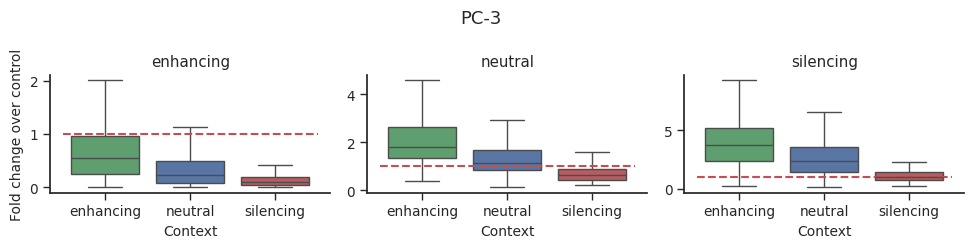

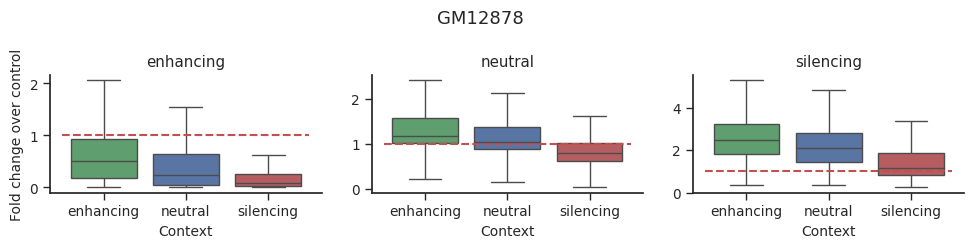

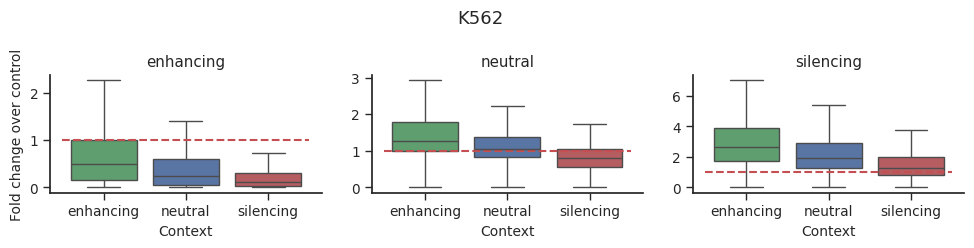

In [142]:
for cell_line, dfs in result_summary.items():    
    ylims = [2, 1.5, 7.5]
    sns.set(font_scale = .9)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 5
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 5
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    
    my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
    
    fig, axes = plt.subplots(1, 3, sharey=False, figsize=[10, 2.5])
    
    for i, (source_context, dfs_by_content) in enumerate(dfs.groupby('source_context')):
        ax= axes[i]
        sns.boxplot(x='target_context', y='normalized', data=dfs_by_content, 
                    hue='target_context', showfliers=False, palette=my_pal, ax=ax)
        ax.set_title(source_context)
        x1, x2 = ax.get_xlim()
        # ax.set_ylim(0, ylims[i])
            
        ax.hlines(1, x1, x2, color='r', linestyles='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=10)
        if i == 0:
            ax.set_ylabel('Fold change over control', fontsize=10)
        else:
            ax.set_ylabel('')
    plt.suptitle(cell_line)
    plt.tight_layout()

In [134]:
dfs_by_content.groupby(['target_context']).count().iloc[:,0]

target_context
enhancing    7812
neutral      3528
silencing    1296
Name: target_id, dtype: int64

<Axes: xlabel='target_context', ylabel='normalized'>

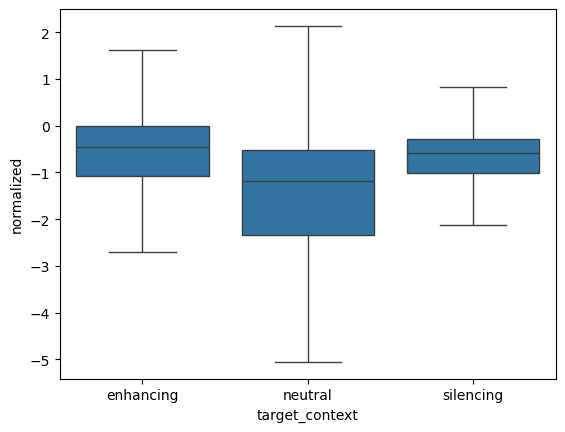

In [112]:
sns.boxplot(x='target_context', y='normalized', data=dfs[dfs['source_context']=='enhancing'], showfliers=False)

In [105]:
df_context

,Unnamed: 0,delta mean,delta std,path,context,cell line,source_id
0,1368,0.952206,0.010117,../results/context_dependence_test/enformer/PT...,enhancing,GM12878,PTPN18_chr2_130356055_+
1,3376,0.987738,0.002243,../results/context_dependence_test/enformer/GP...,enhancing,GM12878,GPATCH1_chr19_33081180_+
2,1228,0.975999,0.008139,../results/context_dependence_test/enformer/FA...,enhancing,GM12878,FAN1_chr15_30903892_+
3,1236,0.981676,0.002518,../results/context_dependence_test/enformer/ZN...,enhancing,GM12878,ZNF729_chr19_22286440_+
4,3361,0.986453,0.000946,../results/context_dependence_test/enformer/GE...,enhancing,GM12878,GEMIN6_chr2_38778209_+
...,...,...,...,...,...,...,...
346,570,-1.619146,0.103331,../results/context_dependence_test/enformer/PL...,silencing,GM12878,PLD5P1_chr10_38094367_+
347,569,-1.292326,0.178192,../results/context_dependence_test/enformer/ZN...,silencing,GM12878,ZNF37A_chr10_38094335_+
348,563,-0.506940,0.144665,../results/context_dependence_test/enformer/HS...,silencing,GM12878,HSD17B7_chr1_162790722_+
349,1009,-0.620151,0.150173,../results/context_dependence_test/enformer/ZN...,silencing,GM12878,ZNF286A_chr17_15699718_+


In [83]:
df

,target_id,swapped,source_wt,source_id,target_wt
0,PTPN18_chr2_130356055_+,148.022247,55.690262,MAN2B2_chr4_6575188_+,148.022247
1,GPATCH1_chr19_33081180_+,242.311646,55.690262,MAN2B2_chr4_6575188_+,305.488098
2,FAN1_chr15_30903892_+,133.911469,55.690262,MAN2B2_chr4_6575188_+,138.511765
3,ZNF729_chr19_22286440_+,30.070202,55.690262,MAN2B2_chr4_6575188_+,138.704193
4,GEMIN6_chr2_38778209_+,102.701157,55.690262,MAN2B2_chr4_6575188_+,304.113708
...,...,...,...,...,...
346,PLD5P1_chr10_38094367_+,3.273960,55.690262,MAN2B2_chr4_6575188_+,92.097153
347,ZNF37A_chr10_38094335_+,3.603881,55.690262,MAN2B2_chr4_6575188_+,92.025795
348,HSD17B7_chr1_162790722_+,23.326393,55.690262,MAN2B2_chr4_6575188_+,91.745506
349,ZNF286A_chr17_15699718_+,12.332714,55.690262,MAN2B2_chr4_6575188_+,123.480347
